In [171]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import simpson

The following cell is just to make timed calls of functions to see where we are wasting computational time

In [172]:
import time
def timed_call(label, func, *args):
    '''input:
    label: str, label for the function being timed,
    func: callable, function to be timed,
    *args: positional arguments for the function,
    '''
    start = time.time()
    result = func(*args)
    print(f"{label} took {time.time() - start:.6f} seconds")
    return result

## MEAN FIELD METHOD

In this relation we want to compute some ground state properties of a system of N particles described by the generic Hamiltonian:
$$
\hat{H} = \sum_{i=1}^{N} \left( \frac{-\hbar^2}{2m} \nabla^2_i + V_{\text{ext}}(\mathbf{r}_i) \right) + \frac{1}{2} \sum_{i\neq j} v(\mathbf{r}_i, \mathbf{r}_j)
$$
where $\vec{r}_1 ... \vec{r}_N$ are the coordinates of our N particles, $V_{ext}=\frac{1}{2}m\omega^2r^2$ is an harmonic external field and $v$ is the interaction potential which we suppose being
$$
v\left( \mathbf{r}, \mathbf{r'} \right) = 4\pi \frac{\hbar^2}{m} a  \delta(\mathbf{r} - \mathbf{r'})
$$
In the mean field approximation we assume that the wave function can be written as a product of single particle functions:
$$
\Psi(\mathbf{r}_1 \dots \mathbf{r}_N) = \hat{P}_{s,a} \phi_1(\mathbf{r}_1) \phi_2(\mathbf{r}_2) \dots \phi_N(\mathbf{r}_N)   \quad\quad\quad  \phi(\mathbf{r})=\frac{\phi(r)}{r}\frac{1}{\sqrt{4 \pi}}
$$
and since we want to model a boson system the permutation operator has the form
$$
\hat{P}_s = \frac{1}{\sqrt{N!}} \sum_{\hat{P}} \hat{P}
$$
To minimize the expectation value we use the variational method which, with the assumption of single particle wave function normalize to 1, leads to the Gross-Pitaevskij equation (GP):
$$
-\dfrac{1}{2}\dfrac{d^2}{dr^2}\phi(r)+\dfrac{1}{2}r^2\phi(r)-\dfrac{1}{2}\dfrac{\ell(\ell+1)}{r^2}\phi(r)+Na\left(\dfrac{\phi(r)}{r}\right)^2\phi(r)=\mu\phi(r)
$$
where energies are expressed in units of $\hbar\omega$ and lengths are expressed in units of the harmonic oscillator length $a_{ho}=\sqrt{\frac{\hbar}{m\omega}}$. $\phi(r)$ is the radial solution of the signle particle wave function.
Since we are interested in the energy of the ground state we assume the particles in the s-wave state only (l=0) so that we have to solve
$$
-\dfrac{1}{2}\dfrac{d^2}{dr^2}\phi(r)+\dfrac{1}{2}r^2\phi(r)+Na\left(\dfrac{\phi(r)}{r}\right)^2\phi(r)=\mu\phi(r)
$$
By defyning $k^2=2\mu-r^2-2Na\left(\dfrac{\phi(r)}{r}\right)^2$ we can recast the last equation as
$$
\dfrac{d^2}{dr^2}\phi(r)+k^2 \phi(r)=0
$$
which can be solved using Numerov algorithm.

# Numerov algorithm and matching

In [173]:
# Numerov algorithm
def numerov(psi_p, psi_c, i, k, h):
    '''Input: previous wavefunction value psi_p, current wavefunction value psi_c, index, K array, step size h'''
    psi_next = (-psi_p*(1+h**2/12*k[i-1])+2*psi_c*(1-(5*h**2)/12*k[i]))/((1+h**2/12*k[i+1]))
    return psi_next

from numba import njit  # Import the Numba JIT compiler

@njit(fastmath=True)
#do not use numerov_fast. it is much slower than normal numerov despite the name ^_^
def numerov_fast(psi_p, psi_c, i, k, h):
    """
    Input: Same as original
    """
    h12 = h**2 / 12  # Pre-compute constant
    k_im1 = k[i-1]    # Load values once
    k_i = k[i]
    k_ip1 = k[i+1]
    
    numerator = (-psi_p * (1 + h12 * k_im1) + 
                 2 * psi_c * (1 - 5 * h12 * k_i))
    denominator = (1 + h12 * k_ip1)
    
    return numerator / denominator

In [174]:
#wavwfunction normalization
def normalization(psi, h):
    '''Input: wavefunction psi, step size h''' 
    psi_squared_integrated = np.sum(np.abs(psi)**2) * h # integrate |psi|^2 over the range
    normalization_constant = 1/np.sqrt(psi_squared_integrated) # normalization factor
    return np.array(psi)*normalization_constant # normalized wavefunction

For computational stability we decide to implement Numerov's algorithm only for $R(r)^{n\ell}$ (in the previous paragraph $\phi(r)$), the radial part of the wavefunction 
$$
\psi(r, \theta, \phi) = \frac{R(r)^{n\ell}}{r} Y_{\ell m}(\theta,\phi)
$$
When the total wavefunction is required we will simpli divide by $r$

In [175]:
# Finding the solution forward
def forward_solution(r,E,N,v,h):
  '''Input: r array, energy E, number of points N, potential v array, step size h'''
  #energy E is a scalar
  phi=[]
  phi.append(0)
  phi.append(h)

  K=[]
  for j in range(N):
    K.append(2*E-r[j]**2-v[j])

  for i in range(1,N-1,1):
    phi.append(numerov(phi[i-1],phi[i],i,K,h))

  return phi

#Findind the solution backward
def backward_solution(r,E,N,v,h):
  '''Input: r array, energy E, number of points N, potential v array, step size h'''
  #energy E is a scalar
  
  #To find the solution backward, we need to reverse the order of the r and psi arrays to use the Numerov algorithm
  r = r[::-1]
  phi_=[]

  phi=[] #initializing the tail
  phi.append(math.exp(-0.5*(r[0])**2))
  phi.append(math.exp(-0.5*(r[1])**2))

  K=[]
  for j in range(N):
    K.append(2*E-r[j]**2-v[j])

  for i in range(1,N-1,1):
    phi.append(numerov(phi[i-1],phi[i],i,K,h))

  phi_.append(phi[::-1])
  return phi_

In [176]:
# Testing the Numerov algorithm
N_test = 10000
L_test = 5
numerov_test_h = L_test/N_test

numerov_test_E = 1.5 # forward_solution and backward_solution read energy as a scalar
numerov_test_E_array = [1.5] # forward_solution and backward_solution read energy as a scalar
#Na = 0

r_test = np.linspace(0.0001, L_test, N_test) # r values from 0 to L with N points

numerov_test_v = np.zeros(N_test)
numerov_test_psi = np.zeros(N_test) # initialize the wavefunction array
#for j in range(N):
    #v.append(2*Na*(psi[j]**2/r[j]**2))

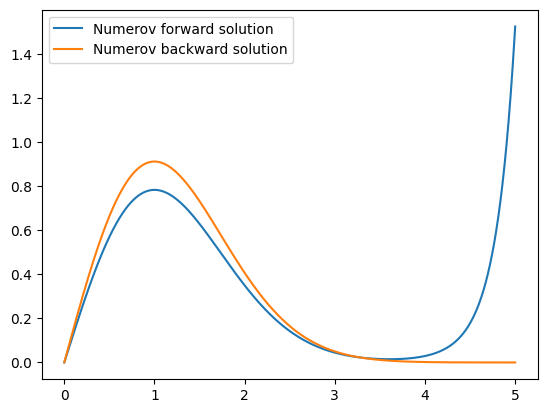

In [177]:
plt.plot(r_test,normalization(forward_solution(r_test,numerov_test_E,N_test,numerov_test_v,numerov_test_h),numerov_test_h),label='Numerov forward solution')
plt.plot(r_test,normalization(backward_solution(r_test,numerov_test_E,N_test,numerov_test_v,numerov_test_h)[0],numerov_test_h),label='Numerov backward solution')
plt.legend()

We do see how the how the solution obtained with the forward procedure diverges, a matching is required.
We choose the classical inversion point for an harmonic potential which is the coordinate that satisfy $V(r)=E$. It can be proven that we are in a zone where the solution is smooth with no nodes.

In [178]:
def index_inversion_point(r,r_inversion):
    '''Input: r array, inversion point r_inversion'''
    difference = np.abs(r - r_inversion)
    index = np.argmin(difference)
    return index
    
def log_der(left_psi,right_psi,index,h):
    '''Input: left wavefunction, right wavefunction, index of the inversion point'''
    left_der = np.gradient(left_psi,h)[index]
    right_der = np.gradient(right_psi,h)[index]
    value = left_der / left_psi[index] - right_der / right_psi[index]
    return value    

The potential is

In [179]:
def interaction(r, Na, phi): #interaction potential
    if Na == 0:
        return np.zeros(len(r))
    else:
        return (2*Na*(np.array(phi)**2/np.array(r)**2))

def mixing(v_old,v_new,alpha): #mixing function (for later use)
    v_old = np.array(v_old)
    v_new = np.array(v_new)
    return alpha*v_new + (1-alpha)*v_old

In [180]:
def matching(E, r, N, h, Na,phi=None):
    '''Input: energy E, r array, initial wavefunction phi_guess, number of points N, Na, step size h'''
    #here the energy has to be an array!
    if Na == 0:
        v = np.zeros(N) 
    elif Na != 0 and phi is None:
        raise ValueError("Argument 'phi' is required when Na != 0")
    else:
        v = interaction(r, Na, phi) #potential array
    
    xi = [] #here we save the mismatch values
    phi_normalized = [] #here we save the normalized wavefunctions

    for x in range(len(E)): #for each energy we calculate the matching

        energy = E[x] #savign the value of the energy
        r_k = np.sqrt(2*energy) #ideal inversion point

        left_phi = forward_solution(r,energy,N,v,h)
        right_phi = backward_solution(r,energy,N,v,h)[0]
        index = index_inversion_point(r,r_k)
        value = log_der(left_phi,right_phi,index,h)
        xi.append(value)

        #ratio of the wavefunctions at the inversion point to match amplitudes
        ratio = left_phi[index] / right_phi[index] 
        
        #wavefunction might have different signs 
        if left_phi[index] / right_phi[index] < 0: 
            ratio = -ratio
            right_phi = ratio * np.array(right_phi)
        else:
            right_phi = ratio * np.array(right_phi)

        #matching the wavefunctions
        phi= []
        phi.append(left_phi[:index])
        phi.append(right_phi[index:])
        phi = np.concatenate(phi)

        phi_normalized = normalization(phi, h)


    return phi_normalized , xi

In [181]:
def matching_v2(energy, r, N, h, Na,phi=None):
    '''Input: energy E_value, r array, initial wavefunction phi_guess, number of points N, Na, step size h'''
    #here the energy has to be an array!
    if Na == 0:
        v = np.zeros(N) 
    elif Na != 0 and phi is None:
        raise ValueError("Argument 'phi' is required when Na != 0")
    else:
        v = interaction(r, Na, phi) #potential array
    
    phi_normalized = [] #here we save the normalized wavefunctions

    r_k = np.sqrt(2*energy) #ideal inversion point

    left_phi = forward_solution(r,energy,N,v,h)
    right_phi = backward_solution(r,energy,N,v,h)[0]
    index = index_inversion_point(r,r_k)
    xi = log_der(left_phi,right_phi,index,h)

    #ratio of the wavefunctions at the inversion point to match amplitudes
    ratio = left_phi[index] / right_phi[index] 
    
    #wavefunction might have different signs 
    if left_phi[index] / right_phi[index] < 0: 
        ratio = -ratio
        right_phi = ratio * np.array(right_phi)
    else:
        right_phi = ratio * np.array(right_phi)

    #matching the wavefunctions
    phi= []
    phi.append(left_phi[:index])
    phi.append(right_phi[index:])
    phi = np.concatenate(phi)

    phi_normalized = normalization(phi, h)


    return phi_normalized, xi

Normalization of the wavefunction:  1.0000000000000047


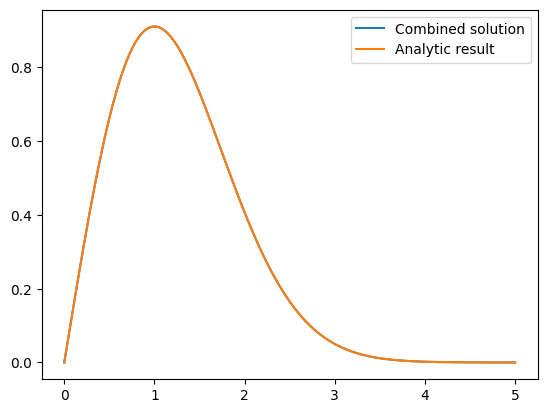

In [182]:
numerov_test_E_array = [1.5] # forward_solution and backward_solution read energy as a scalar

plt.plot(r_test,matching(numerov_test_E_array, r_test, N_test, numerov_test_h, 0)[0],label='Combined solution')
plt.plot(r_test,np.pi**(-0.25)*np.exp(-0.5*np.array(r_test)**2)*2*np.array(r_test),label='Analytic result')
#$plt.plot(r_test,np.pi**(-0.25)*np.exp(-0.5*np.array(r_test)**2)*2*np.array(r_test),label='Analytic result')
plt.legend()
print("Normalization of the wavefunction: ", sum(np.abs(matching(numerov_test_E_array, r_test, N_test, numerov_test_h,0)[0])**2 * numerov_test_h))

# Solving GP 
We can now proceed to find the ground state of a gas of cold atoms (ℓ=0) 

old algorithm

In [183]:
def GP(E,r,N,h,Na, phi=None):
    '''Input: E = array of trial energies'''
    eigenvalue = []
    eigenfunction = []

    xi= matching(E, r, N, h, Na, phi)[1]

    eigenvalue = []
    eigenfunction = []

    for i in range(len(E) - 1):
        if xi[i] * xi[i+1] < 0:
            energies = np.linspace(E[i], E[i+1], 100)
            finer_xi = matching(energies, r, N, h, Na, phi)[1]
            
            for j in range(1, len(energies)):
                if finer_xi[j-1] * finer_xi[j] < 0:
                    eigenvalue.append(energies[j])
                    eigenfunction.append(matching([energies[j-1]], r, N, h,Na,phi)[0])
                    break  # break inner loop
            break  # break outer loop

    return eigenvalue, eigenfunction, xi

new algorithm (with newton's bisection): cheeky xi has multiple zeros (multiple bound states), so we need to be careful to pick up the lowest energy one!

In [184]:
E_array_serious = np.linspace(1.4, 1.6, 100)

eigenvalue0, eigenfunction0,_ = GP(E_array_serious,r_test,N_test,numerov_test_h,0)
print(eigenvalue0)
#print(eigenfunction0_v2)

ValueError: too many values to unpack (expected 3)

Text(0.5, 1.0, 'Harmonic Oscillator ground state wavefunction')

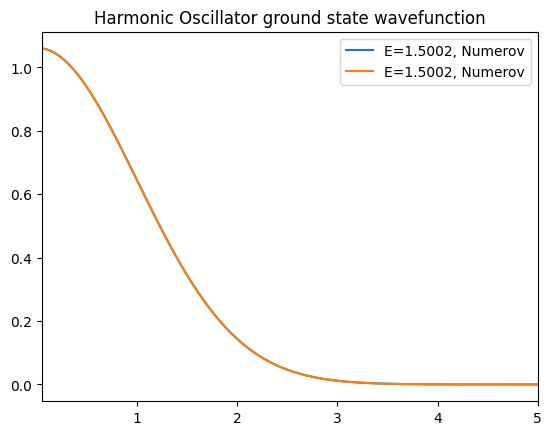

In [17]:
plt.plot(r_test,normalization(eigenfunction0[0]/r_test,numerov_test_h),label=f"E={float(eigenvalue0[0]):.4f}, Numerov") #still normalized??
plt.xlim(0.05,5)
plt.legend()
plt.title('Harmonic Oscillator ground state wavefunction')

We plot now the density of the system for $N_A$ particles

In [18]:
N_A = 6.02214076e23

rho = N_A * eigenfunction0[0]**2 / np.array(r_test)**2

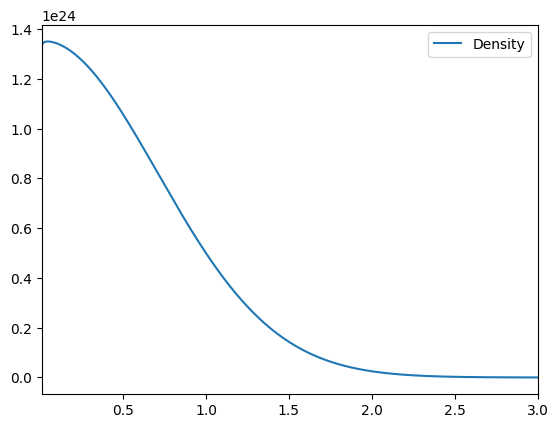

In [19]:
plt.plot(r_test,rho,label='Density')
plt.xlim(0.01,3)
plt.legend()

## Flowchart for the self-consistent solution of the mean field equations (both GP and HF)

1) Guess initial reasonable function $\phi$
2) Evaluate the effective potential $v$ ,which contains both the terms $V_{ext}(\vec{r})$ and $v(\vec{r},\vec{r}')$, and if this is not the first step combine it with the one of th eprevious iteration as $v_{new}=\alpha v_{new}+(1-\alpha)v_{old}$
3) Solve HF-GP and get a $\phi_{new}$ to calculate the energy
4) If the energy satisfy convergence criteria stop, otherwise go back to 2. and solve the potential with $\phi_{new}$ to get a new effective potential $v_{new}$

Since now we are goign to set $Na\neq 0$ another term will enter the potential and phi_guess starts to be fundamental.
To test the convergence we choose a threshold $\epsilon = 0.0001$, thus the self-consistent iteration will proceed until $\Delta E < \epsilon$.
We need now to discuss how to evaluate the energy at each step. There are two possible ways.

The first way to evaluating the energy is through the evaluation of the energy functional:
$$ \frac{E[\phi]}{N}=-\dfrac{1}{2}∫ ϕ(r)\left(\dfrac{d^2}{dr^2}\phi(r)\right) dr + \dfrac{1}{2}∫|ϕ(r)|^2 r^2 dr+ \dfrac{1}{2}Na\int|\phi(r)|^2\left(\dfrac{\phi(r)}{r}\right)^2 dr
$$

The second one comes from the meaning of the eigenvalue $\mu$, thus:
$$\frac{E_{\mu}}{N}=\mu-E_{int}=\mu-\dfrac{1}{2}Na\int_0^{\infty}|\phi(r)|^2\left(\dfrac{\phi(r)}{r}\right)^2\,dr\,.$$
where $\phi$ is the radial part of the wavefunction, obtained in the solution of the GP equation.

In [20]:
def total_energy(r_0,psi,h,Na):
    A = np.array(psi)  
    r = np.array(r_0) 

    #first and second derivatives
    A_prime = np.gradient(A, h)
    A_second = np.gradient(A_prime, h)

    #calculating the functionqal energy
    functional_energy = -0.5*simpson(A*A_second,r,dx=h) + 0.5*simpson(A**2*r**2,r,dx=h) + 0.5*Na*simpson(A**4/r**2,r,dx=h)

    return functional_energy

total_energy_eval = total_energy(r_test,eigenfunction0[0],numerov_test_h,0)
print(f"Total energy: {total_energy_eval:.10f}")

Total energy: 1.5003527333


In [21]:
def total_energy_mu(r_0,psi,h,eigenvalue,Na):
    A = np.array(psi)  
    r = np.array(r_0) 

    total_energy = eigenvalue -  0.5*Na*simpson(A**4/r**2,r,dx=h)

    return total_energy

total_energy1 = total_energy_mu(r_test,eigenfunction0[0],numerov_test_h,eigenvalue0[0],0)
print(f"Total energy: {total_energy1}")


Total energy: 1.5002346699316396


Na=0, mu = 1.5045045045045045, Energy = 1.5003798603503442, Energy_mu = 1.5045045045045045, Delta E: 0.0041246442
Na=0.01, mu = 1.5135135135135136, Energy = 1.5043695237189012, Energy_mu = 1.5095172793933367, Delta E: 0.0051477557
Na=0.1, mu = 1.5855855855855856, Energy = 1.5389644553564428, Energy_mu = 1.5479928542027863, Delta E: 0.0090283988
Na=1, mu = 2.1621621621621623, Energy = 1.8353208388105182, Energy_mu = 1.954881231726119, Delta E: 0.1195603929
Na=10, mu = 3.765765765765766, Energy = 3.8081378801385792, Energy_mu = 2.960904198821791, Delta E: 0.8472336813
Na=100, mu = 5.54954954954955, Energy = 11.25678000302779, Energy_mu = -1.1197515282346764, Delta E: 12.3765315313


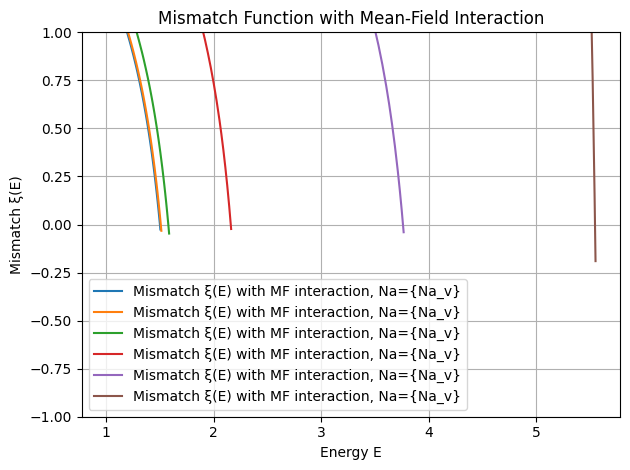

In [35]:
#Choose your energy scan range
E_start = 1.0       # Lower bound of energy
E_end = 10.0        # Upper bound of energy
n_points = 1000   # Resolution of scan

# Generate energy values
E_vals = np.linspace(E_start, E_end, n_points)
delta_e_arr = []
# Values to test for the new run
Na_values = [0,0.01, 0.1, 1, 10, 100]
# Evaluate xi(E) for each energy
phi_gs = matching_v2(1.5,r_test,N_test,numerov_test_h,Na=0)[0]  
for Na_v in Na_values:
    if Na_v == 0:
        phi_gs = matching_v2(1.5,r_test,N_test,numerov_test_h,Na=0)[0]  # NI groundsstate wf
        xi_vals_new = [matching_v2(E,r_test,N_test,numerov_test_h,Na=0)[1] for E in E_vals]  
    xi_vals_new = [matching_v2(E,r_test,N_test,numerov_test_h,Na=Na_v,phi=phi_gs)[1] for E in E_vals]   
    # Find the index of the first zero crossing (sign change)
    zero_index = None
    for i in range(len(xi_vals_new) - 1):
        if xi_vals_new[i] * xi_vals_new[i + 1] < 0:
            zero_index = i + 1  # Include the first point *after* the sign change
            break
    # Truncate arrays
    if zero_index is not None:
        E_vals_trunc = E_vals[:zero_index + 1]
        xi_vals_trunc = xi_vals_new[:zero_index + 1]
    else:
        E_vals_trunc = E_vals
        xi_vals_trunc = xi_vals_new
        print("Warning: No zero crossing found.")
    phi_final = matching_v2(E_vals_trunc[-1], r_test, N_test, numerov_test_h, Na=Na_v, phi = phi_gs)[0]
    energy = total_energy(r_test, phi_final, numerov_test_h, Na_v)
    energy_mu = total_energy_mu(r_test, phi_final, numerov_test_h, E_vals_trunc[-1], Na_v)
    delta_e_arr.append(np.abs(energy-energy_mu))
    print(f"Na={Na_v}, mu = {E_vals_trunc[-1]}, Energy = {energy}, Energy_mu = {energy_mu}, Delta E: {delta_e_arr[-1]:.10f}")
    plt.plot(E_vals_trunc, xi_vals_trunc, label='Mismatch ξ(E) with MF interaction, Na={Na_v}')
plt.xlabel('Energy E')
plt.ylabel('Mismatch ξ(E)')
plt.title('Mismatch Function with Mean-Field Interaction')
plt.ylim(-1, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




## 2. Solve one iteration of GP


ok 0.01
[1.5085427135678393]
ok 0.1
[1.5783919597989953]
ok 1
[2.1587939698492464]
ok 10
[3.7597989949748745]
ok 100
[5.545226130653266]


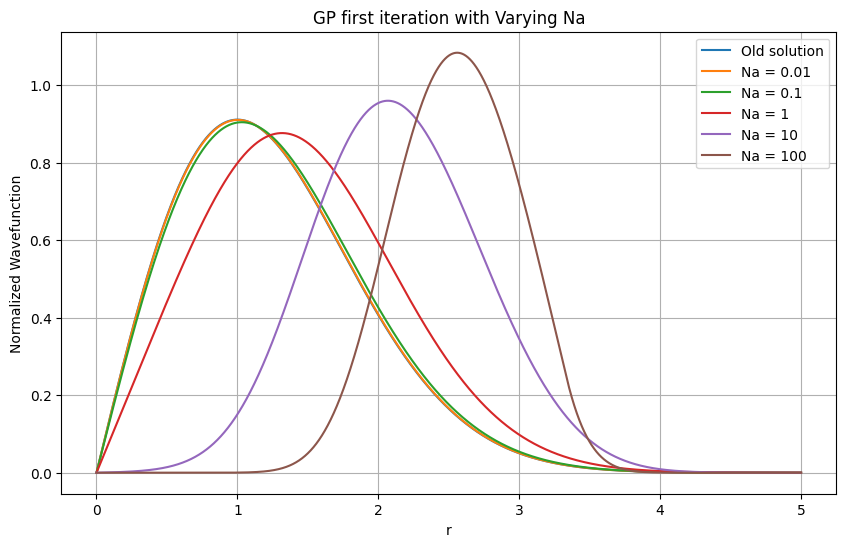

In [23]:
import matplotlib.pyplot as plt

# Initial run with Na = 0 to get the old solution
E_array_final = np.linspace(0.1, 10, 200) #need to introduce a new energy array because the Na = 100 case has ridiculous energy
E_lim_array = [[1.45,1.55], [1.55,2.5], [1.6,1.9], [1.5,10], [1.5,10]]
eigenvalue_old, eigenfunction_old = GP(E_array_final, r_test, N_test, numerov_test_h, 0)
#eigenvalue_old_v2, phi_old_v2 = GP_v2(E_lim_array[0][0],E_lim_array[0][1], r_test, N_test, numerov_test_h, 0)
phi_old = eigenfunction_old[0]


plt.figure(figsize=(10, 6))
plt.plot(r_test, normalization(phi_old, numerov_test_h), label='Old solution')

# Loop over different Na values, reusing phi_old as initial guess
for i in range(len(Na_values)):
    eigenvalue_new, phi_new = GP(E_array_final, r_test, N_test, numerov_test_h, Na_values[i], phi= phi_old)
    print('ok', Na_values[i])
    print(eigenvalue_new)
    plt.plot(r_test, normalization(phi_new, numerov_test_h)[0], label=f'Na = {Na_values[i]}')

plt.xlabel('r')
plt.ylabel('Normalized Wavefunction')
plt.title('GP first iteration with Varying Na')
plt.legend()
plt.grid(True)
plt.show()


Putting everything together: we construct a recursive function which builds from scratch the non-interacting (Na=0) ground state, and then plugs into Gross-Pitaevskii the potential given by this wavefunction, which is then solved with numerov (GP). The new guess of the wavefunction is a l.c. of the old and new one, with mixing parameter alpha s.t. we are mostly keeping the old function. This way convergence is smoother.

In [131]:
def GP_recursion(E_min,E_max,Na,alpha, N, r,h,threshold=0.0001,phi_old = None, eigenvalue_old = None): 
    '''
    this function does everything. It takes in the basic parameters, evaluates the non-interacting wavefunction, 
    then introduces the interaction potential and iteratively solves the GP equation until convergence is reached.

    input:  Na, alpha, N, r, h, are what you expect
            threshold is set to 0.0001 by default, sets the convergence criterion (deltaEnergy > threshold)

    output: phi_new is the final guess of the wavefunction,
            energy is the array of energies at each iteration,
            count is the number of iterations needed for convergence
    '''
    DeltaEnergy = 10 #initialise DeltaEnergy to a safe value
    DeltaEnergyPrevious = 10 #likewise for DeltaEnergyPrevious

    E = np.linspace(E_min,E_max,100)
    energy = []
    energy_mu = []

    if phi_old is None:
        eigenvalue_old, eigenfunction_old,_ = GP(E, r, N, h, 0) #initial guess of the wavefunction
        phi_old = eigenfunction_old[0]
        phi_new = [] #initialise the new wavefunction

    
    #evaluatong the energy
    energy.append(total_energy(r,phi_old,h,Na))
    energy_mu.append(total_energy_mu(r,phi_old,h,eigenvalue_old,Na))

    count = 1 #keep track of the eigenvalues to determine DeltaEnergy

    while DeltaEnergy > threshold or np.abs(DeltaEnergy-DeltaEnergyPrevious) > threshold:
        E_old = E
        eigenvalue_new, eigenfunction_new, xi = GP(E_old,r,N,h,Na,phi_old)
        phi_new = eigenfunction_new[0]
        #phi_new = alpha*phi_new_test + (1-alpha)*phi_old #ts is for stabler convergence--using the mixing parameter alpha

        v_old = interaction(r,Na,phi_old)
        v_new = interaction(r,Na,phi_new)

        v = mixing(v_old,v_new,alpha)

        energy.append(total_energy(r,phi_new,h,Na))
        energy_mu.append(total_energy_mu(r,phi_new,h,eigenvalue_new,Na))

        #DeltaEnergy = np.abs(energy[count] - energy[count-1])
        DeltaEnergy = np.abs(energy[count] - energy_mu[count])
        #DeltaEnergyPrevious = np.abs(energy[count-1] - energy[count-2])
        DeltaEnergyPrevious = np.abs(energy[count-1] - energy_mu[count-1])

        #print(eigenvalues[count],DeltaEnergy)     functional_energy[count]

        #print(energy[count],DeltaEnergy) 
        print(eigenvalue_new,DeltaEnergy) 
        
        phi_old = np.array(phi_new)
        E = [round(z,3) for z in np.arange(eigenvalue_new[0]-0.5,eigenvalue_new[0]+0.5,0.1)]
        count += 1
    plt.plot(E_old,xi)
    return phi_new, energy, count

[2.172635445362718] [0.08591566]
[2.157848484848485] [0.05285935]


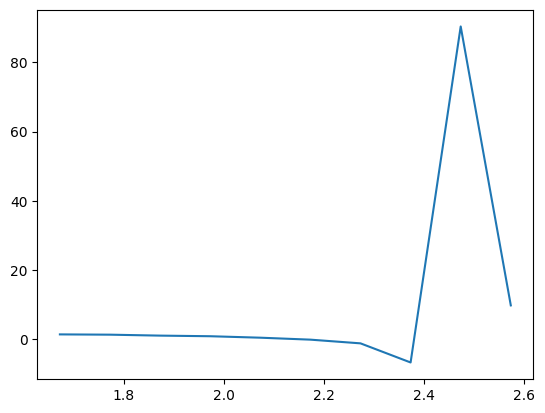

In [133]:
L_test_2 = 10
N_test_2 = 100
h_test_2 = L_test_2/N_test_2
r_test_2 = np.linspace(0.001, L_test_2, N_test_2) # r values from 0 to L with N points

phi_new_test_2, energy_test_2, count_test_2 = GP_recursion(1,10,1,0.1,N_test_2,r_test_2,h_test_2,threshold=0.1)

delta_energy_array = [np.abs(energy_test_2[i] - energy_test_2[i-1]) for i in range(1, len(energy_test_2))]

#plt.plot(delta_energy_array[::])

Now we go on and loop the iteration

0.01
[1.5155392306907458] [0.00610003]
Na = 0.01, Energy = 1.5176441077, Iterations = 2
0.1
[1.5852464034282217] [0.00771761]
Na = 0.1, Energy = 1.5532753124, Iterations = 2
1
[2.164932149780635] [0.08048392]
[2.150858585858586] [0.04601576]
Na = 1, Energy = 1.8506246365, Iterations = 3
10
[3.7303336394245488] [5.49866343]
[3.733030303030303] [5.22669343]
[3.736030303030303] [4.96534722]
[3.738020202020202] [4.71548218]
[3.740020202020202] [4.47567896]
[3.743030303030303] [4.24459224]
[3.7450202020202017] [4.02384198]
[3.748030303030303] [3.81107195]
[3.750020202020202] [3.60794006]
[3.753030303030303] [3.41211587]
[3.756030303030303] [3.22431392]
[3.7580202020202016] [3.04518806]
[3.761030303030303] [2.8724574]
[3.763020202020202] [2.70783854]
[3.766030303030303] [2.54906251]
[3.768020202020202] [2.39786689]
[3.7700202020202016] [2.25297211]
[3.773030303030303] [2.11317906]
[3.775020202020202] [1.98024369]
[3.778030303030303] [1.851945]
[3.780020202020202] [1.7300662]
[3.7820202020202

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[9.215010101010101] [0.14203587]
[9.215] [0.13454982]
[9.2160101010101] [0.12606685]
[9.2170101010101] [0.11761719]
[9.218010101010101] [0.10919069]
[9.2190101010101] [0.1007873]
[9.219] [0.09341475]
Na = 100, Energy = 5.9598596514, Iterations = 1387


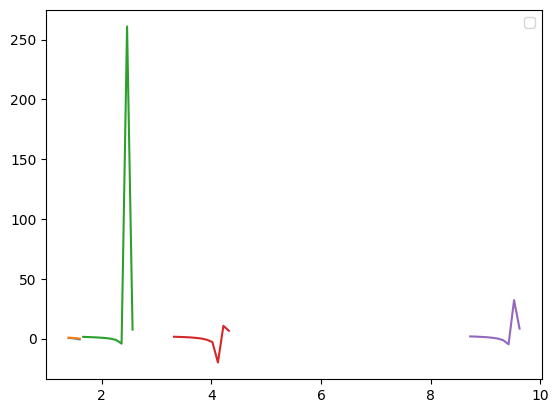

In [149]:
Na_array = [0.01,0.1,1,10,100]
alpha_array = [.1,.1,.1,.01,.0005]
mu_array = [[1.4,1.6], [1.4,1.6], [1.5,2.5], [2,5], [8,10]]
#Na_array = [100]
#alpha_array = [.001]
#mu_array = [[1,10]]
L = 10
N = 200
h = L/N
r = np.linspace(0.0001, L, N) # r values from 0 to L with N points
phi_array = []
energy_array = []
for i in range(len(Na_array)):
    Na = Na_array[i]
    print(Na)
    phi_old = GP(E_array_final, r, N, h, 0)[1][0] #initial guess of the wavefunction
    eigenvalue_old = GP(E_array_final, r, N, h, 0)[0] #initial guess of the wavefunction
    phi_new, energy, count = GP_recursion(mu_array[i][0],mu_array[i][1],Na,alpha_array[i],N,r,h,threshold=0.1, phi_old = phi_old, eigenvalue_old = eigenvalue_old)
    phi_array.append(phi_new)
    energy_array.append(energy)
    print(f"Na = {Na}, Energy = {energy[-1]:.10f}, Iterations = {count}")
    phi_old = phi_new
plt.legend()


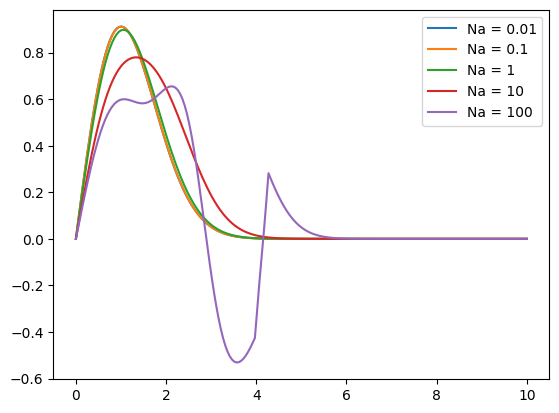

In [150]:
for i in range(len(Na_array)):
    plt.plot(r, normalization(phi_array[i], h), label=f'Na = {Na_array[i]}')
    plt.legend()

3.730945821854913 2.223140495867769
1.9908172635445363 1.740128558310377
3.433425160697888 1.4426078971533518
4.743801652892563 1.3103764921946746
2.9008264462809916 1.842975206611571
4.0 1.0991735537190084
1.953168044077135 2.046831955922865
3.5417814508723597 1.5886134067952247
2.0459136822773187 1.495867768595041
3.3948576675849402 1.3489439853076215
4.746556473829202 1.3516988062442614
2.8604224058769514 1.8861340679522502
3.9908172635445363 1.1303948576675849
1.9403122130394859 2.05050505050505
3.5353535353535355 1.5950413223140496
2.0486685032139578 1.4866850321395777
3.393021120293848 1.34435261707989
4.746556473829202 1.3535353535353538
2.8585858585858586 1.887970615243343
3.98989898989899 1.1313131313131315
1.9393939393939394 2.0505050505050506
3.534435261707989 1.5950413223140494
2.0486685032139578 1.485766758494031
3.393021120293848 1.34435261707989
4.747474747474747 1.3544536271808996
2.859504132231405 1.8879706152433422
3.9908172635445363 1.131313131313131
1.94031221303948

KeyboardInterrupt: 

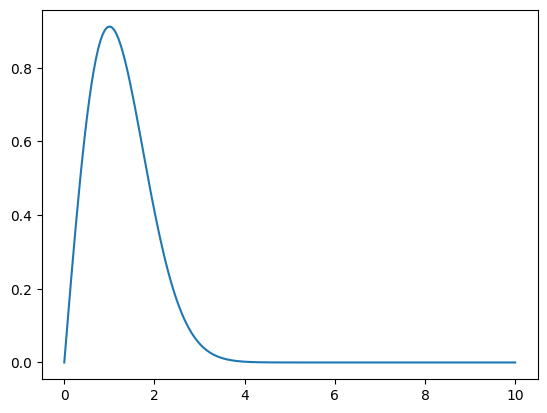

In [169]:
DeltaEnergy = 10
DeltaEnergyPrevious = 10
threshold = 0.00001

E = np.linspace(1,10,100)
eigenvalues = []
eigenfunctions =[]

eigenvalue, eigenfunction, _ = GP(E, r, N, h, 0) #initial guess of the wavefunction

phi_old = eigenfunction[0]
phi_new = []
alpha = 0.001
Na = 10

v = interaction(r,Na,phi_old) #potential for the first iteration  

eigenvalues.append(eigenvalue[0]) #defining the first energy of the system

count = 1 #keep track of the eigenvalues to determine DeltaEnergy

plt.plot(r,phi_old)

while DeltaEnergy > threshold or np.abs(DeltaEnergy-DeltaEnergyPrevious) > threshold:

    eigenvalues.append(GP(E,r,N,h,Na,phi_old)[0][0])
    phi_new = GP(E,r,N,h,Na,phi_old)[1]
    phi_new = phi_new[0]
    
    v_old = interaction(r,Na,phi_old)
    v_new = interaction(r,Na,phi_new)

    v = mixing(v_old,v_new,alpha)

    phi_old = np.array(phi_new)

    DeltaEnergy = np.abs(eigenvalues[count] - eigenvalues[count-1])

    DeltaEnergyPrevious = np.abs(eigenvalues[count-1] - eigenvalues[count-2])

    print(eigenvalues[count],DeltaEnergy)

    count += 1

plt.plot(r,phi_old)

Harmonic oscillator 